In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
apts_price = pd.read_csv("teste_indicium_precificacao.csv")
print(apts_price.shape)

(48894, 16)


In [3]:
print(apts_price.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48894 entries, 0 to 48893
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             48894 non-null  int64  
 1   nome                           48878 non-null  object 
 2   host_id                        48894 non-null  int64  
 3   host_name                      48873 non-null  object 
 4   bairro_group                   48894 non-null  object 
 5   bairro                         48894 non-null  object 
 6   latitude                       48894 non-null  float64
 7   longitude                      48894 non-null  float64
 8   room_type                      48894 non-null  object 
 9   price                          48894 non-null  int64  
 10  minimo_noites                  48894 non-null  int64  
 11  numero_de_reviews              48894 non-null  int64  
 12  ultima_review                  38842 non-null 

**Limpeza e tratamento de Dados** 

In [4]:
#1 checar acomodações anunciadas com preço zero
price_zero = apts_price[apts_price["price"] == 0]
price_zero.head()


,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
23160,18750597,"Huge Brooklyn Brownstone Living, Close to it all.",8993084,Kimberly,Brooklyn,Bedford-Stuyvesant,40.69023,-73.95428,Private room,0,4,1,2018-01-06,0.05,4,28
25432,20333471,★Hostel Style Room | Ideal Traveling Buddies★,131697576,Anisha,Bronx,East Morrisania,40.83296,-73.88668,Private room,0,2,55,2019-06-24,2.56,4,127
25633,20523843,"MARTIAL LOFT 3: REDEMPTION (upstairs, 2nd room)",15787004,Martial Loft,Brooklyn,Bushwick,40.69467,-73.92433,Private room,0,2,16,2019-05-18,0.71,5,0
25752,20608117,"Sunny, Quiet Room in Greenpoint",1641537,Lauren,Brooklyn,Greenpoint,40.72462,-73.94072,Private room,0,2,12,2017-10-27,0.53,2,0
25777,20624541,Modern apartment in the heart of Williamsburg,10132166,Aymeric,Brooklyn,Williamsburg,40.70838,-73.94645,Entire home/apt,0,5,3,2018-01-02,0.15,1,73


In [5]:
# Número de acomodações anunciadas com preço zero
print(f"Número de acomodações anunciadas com preço zero: {len(price_zero)}")

Número de acomodações anunciadas com preço zero: 11


In [6]:
# Preço médio por bairro_principal (bairro)
p_medio_bairro = apts_price.groupby("bairro_group")["price"].mean()

In [7]:
# Preço médio por região menor (bairro)
p_medio_regiao = apts_price[apts_price['price'] != 0].groupby('bairro')['price'].mean().astype(int)
print(p_medio_regiao)

bairro
Allerton            87
Arden Heights       67
Arrochar           115
Arverne            171
Astoria            117
                  ... 
Windsor Terrace    138
Woodhaven           67
Woodlawn            60
Woodrow            700
Woodside            85
Name: price, Length: 221, dtype: int64


In [8]:
# 1.1 Substuir os preços zero pelo preço médio da região, caso seja zero, pelo bairro.
for sub in p_medio_regiao .index:
    apts_price.loc[(apts_price["price"] == 0) & (apts_price["bairro"] == sub), "price"] = p_medio_regiao [sub]
for bairro in p_medio_bairro.index:
    apts_price.loc[(apts_price["price"] == 0) & (apts_price["bairro_group"] == bairro), "price"] = p_medio_bairro[bairro]

price_zero = apts_price[apts_price["price"] == 0]
print(f"Número de acomodações anunciadas com preço zero: {len(price_zero)}")

Número de acomodações anunciadas com preço zero: 0


/var/folders/3r/qz3wvmd90vgfgc8ck8gh_wvm0000gn/T/ipykernel_76128/2123225531.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '87.4967919340055' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  apts_price.loc[(apts_price["price"] == 0) & (apts_price["bairro_group"] == bairro), "price"] = p_medio_bairro[bairro]


In [9]:
# 1.1.2 Verificar se existem valores vázios em outras colunas
apts_price.isnull().sum()

id                                   0
nome                                16
host_id                              0
host_name                           21
bairro_group                         0
bairro                               0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimo_noites                        0
numero_de_reviews                    0
ultima_review                    10052
reviews_por_mes                  10052
calculado_host_listings_count        0
disponibilidade_365                  0
dtype: int64

Através dessa verificação, é possível perceber que 16 locais foram anunciados sem nome, representando apenas 0,03% do volume de 48894 dados, sendo portanto excluidos. Enquanto isso, 21 desses anuncios não apresenta o nome do anunciante(host_name), o tratamento para essa situação será a troca do valor vazio por unknown.
Os maiores impactos pela ausencia de dados são provocados pelas colunas de ultima_review e reviews_por_mes, a falta de 10052 dados representa 20% do banco de dados, e, portanto deve ser tratado de forma adequada. Para isso, no ultima_review a ausencia de valores será substituida pela data mais antiga. Já em reviews_por_mês, será adotado uma estratégia na qual substitui a ausencia de valores por 0.

In [10]:
# 1.1.3 Exclusão de imóveis sem nome
apts_price.dropna(subset=["nome"], inplace=True)

# 1.1.4 Substituir host_name vázio por unknown
apts_price["host_name"].replace('', "Unknown", inplace=True)
apts_price["host_name"].fillna('Unknown', inplace=True)

# 1.1.5 Substituir ultima_review com valores ausentes pela data mais antiga
apts_price['ultima_review'] = pd.to_datetime(apts_price["ultima_review"])
ultima_review = apts_price["ultima_review"].fillna(apts_price["ultima_review"].min(), inplace=True)

# 1.1.6 Substituir reviews_po_mes com valores ausentes por 0
reviews_por_mes: apts_price['reviews_por_mes'].fillna(0, inplace=True)

/var/folders/3r/qz3wvmd90vgfgc8ck8gh_wvm0000gn/T/ipykernel_76128/2420827670.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  apts_price["host_name"].replace('', "Unknown", inplace=True)
/var/folders/3r/qz3wvmd90vgfgc8ck8gh_wvm0000gn/T/ipykernel_76128/2420827670.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting

In [11]:
apts_price.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48878 entries, 0 to 48893
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   id                             48878 non-null  int64         
 1   nome                           48878 non-null  object        
 2   host_id                        48878 non-null  int64         
 3   host_name                      48878 non-null  object        
 4   bairro_group                   48878 non-null  object        
 5   bairro                         48878 non-null  object        
 6   latitude                       48878 non-null  float64       
 7   longitude                      48878 non-null  float64       
 8   room_type                      48878 non-null  object        
 9   price                          48878 non-null  float64       
 10  minimo_noites                  48878 non-null  int64         
 11  numero_de_reviews   

**Identificar Outliers**

Para identificar esse valores será utilizado histogramas e gráficos de boxplot

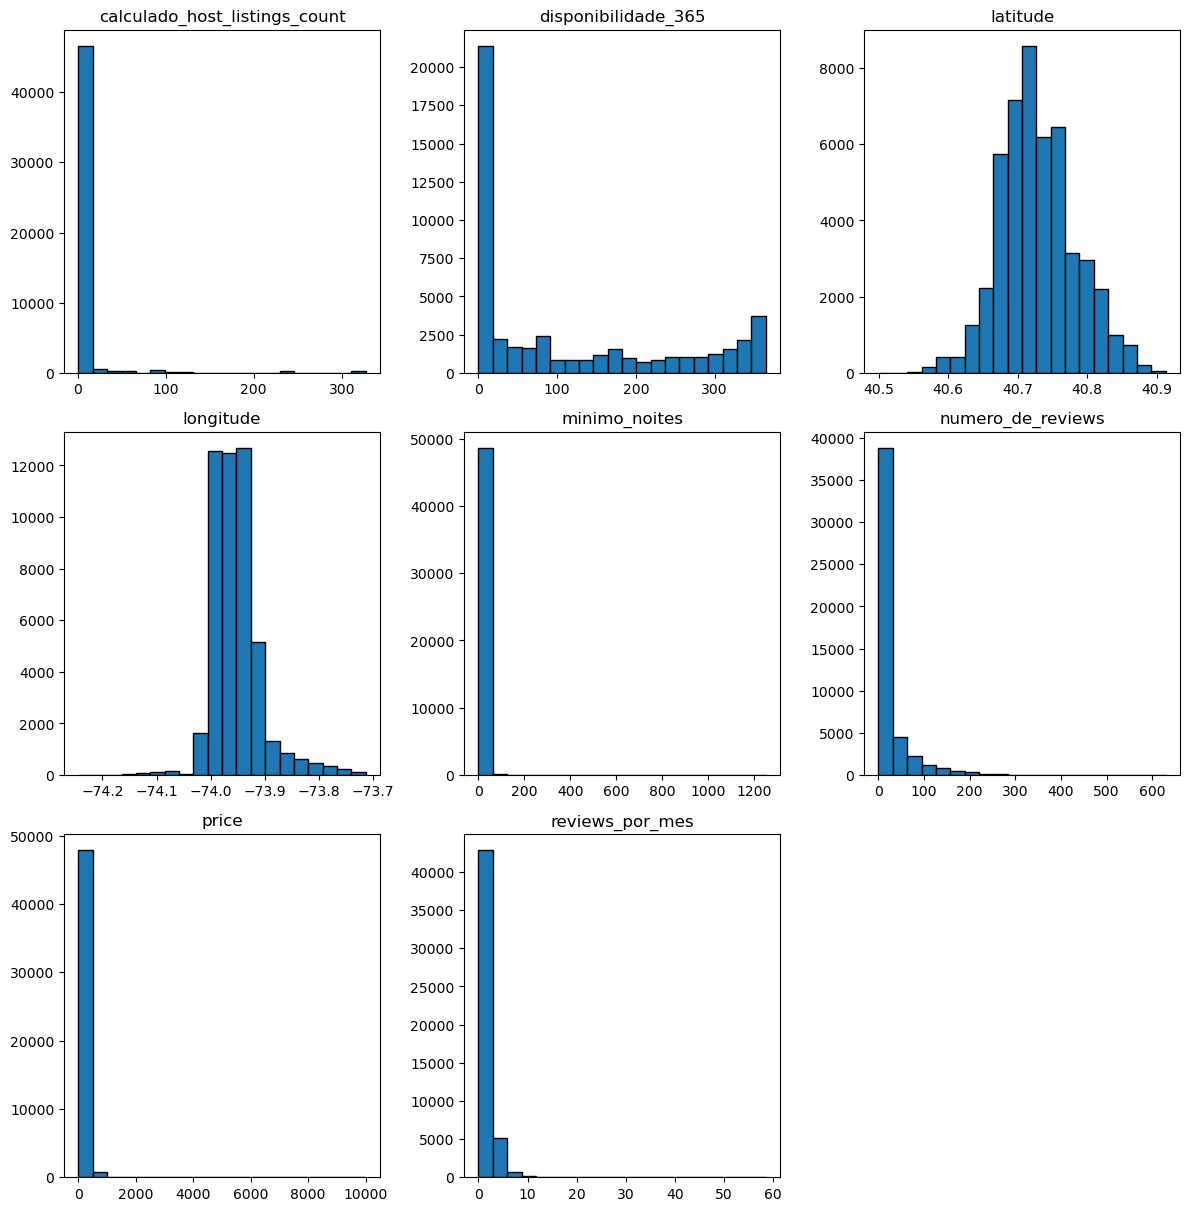

In [12]:
# 1.2 Histogramas
numerical_vars = apts_price.select_dtypes(include=['float64', 'int64']).columns
len_numerical_vars = len(numerical_vars)

n_linhas = int(np.ceil(len_numerical_vars / 3))
n_colunas = min(len_numerical_vars, 3)

# 1.2.1 criar subplots
fig, axs = plt.subplots(n_linhas, n_colunas, figsize=(4 * n_colunas, 4 * n_linhas))

if n_linhas * n_colunas > 1:
    axs = axs.ravel()
else:
    axs = [axs]

for i, column in enumerate(numerical_vars.difference(['id', 'host_id'])):
    axs[i].hist(apts_price[column], bins=20, edgecolor='black')
    axs[i].set_title(f'{column}')
    
for j in range(len(numerical_vars.difference(['id', 'host_id'])), len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.savefig('histograma.png')
plt.show()

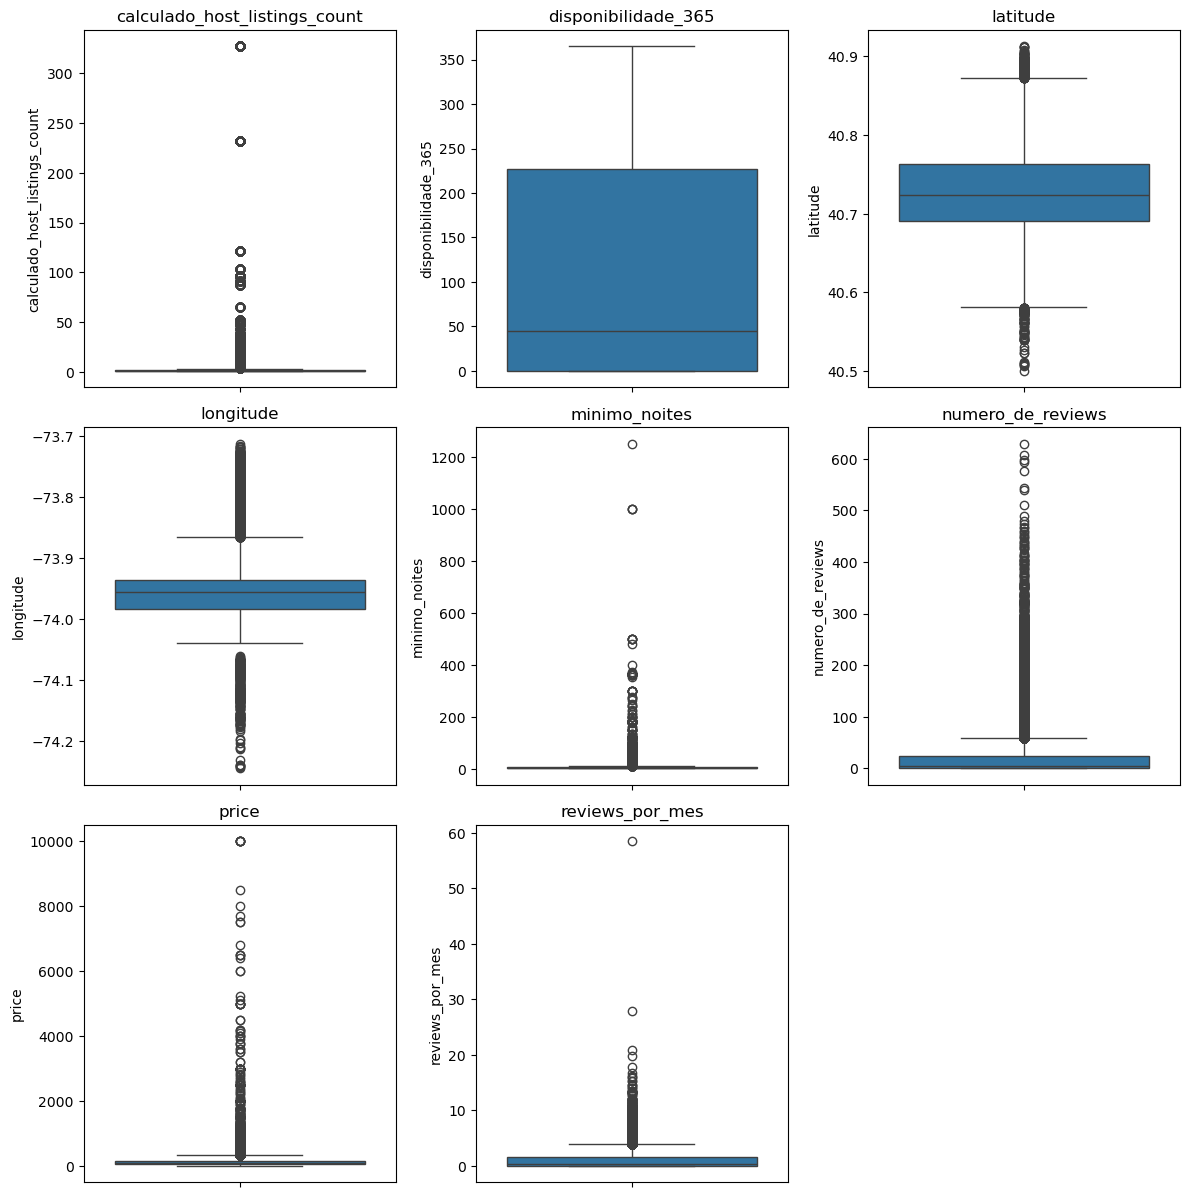

In [13]:
# Boxplot
fig, axs = plt.subplots(n_linhas, n_colunas, figsize=(4 * n_colunas, 4 * n_linhas))

for i, column in enumerate(numerical_vars.difference(['id', 'host_id'])):
    row = i // n_colunas
    col = i % n_colunas
    sns.boxplot(y=apts_price[column], ax=axs[row, col])
    axs[row, col].set_title(column)

for j in range(len(numerical_vars.difference(['id', 'host_id'])), n_linhas * n_colunas):
    fig.delaxes(axs.flatten()[j])

plt.tight_layout()
plt.savefig('boxplots.png')
plt.show()

Pelos histogramas é possível perceber valores discrepantes em vários blocos, especialmente no histograma de preços, mínimo_noites e
calculado_host_listings_count. Contudo, não será feito o tratamento para outliers, considerando a complexidade do mercado de aluguéis
em Nova York, as especificidades de cada região e a variabilidade de preço, qualquer maior tratamento poderia distocer interpretação
dos dados, ainda que exista a penalidade de prejudicar o futuro modelo.

Text(0, 0.5, 'Quantidade')

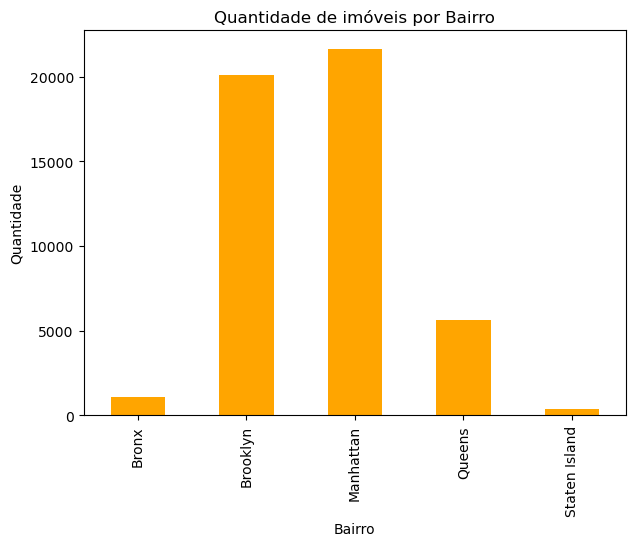

In [14]:
#2- Dados Bairros Principais(bairros_group)
# 2.1 Quantidade de imóveis por bairro
n_casas_bairro = apts_price.groupby("bairro_group").size()

n_casas_bairro.plot(kind="bar", figsize=(7, 5), color="orange", title="Quantidade de imóveis por Bairro")
plt.xlabel("Bairro")
plt.ylabel("Quantidade")

In [15]:
# 1.2 Acomodaçao mais comum por bairro
acomodacao_bairro = {}

#1.2.1 Contabilizar os tipos de acomodação por bairro
for _, row in apts_price.iterrows():
    bairro = row.get("bairro_group", None)
    type_room = row.get("room_type", None)
    if bairro is None or type_room is None:
        continue
    if bairro not in acomodacao_bairro:
        acomodacao_bairro[bairro] = {"Entire home/apt": 0, "Private room": 0, "Shared room": 0}
    acomodacao_bairro[bairro][type_room] += 1

dados_tabela = []
for bairro, acomodacao in acomodacao_bairro.items():
    tipo_mais_comum_bairro = max(acomodacao, key=acomodacao.get)
    total_mais_comum = acomodacao[tipo_mais_comum_bairro]
    dados_tabela.append({
        "Bairro": bairro,
        "Tipo Mais Comum": tipo_mais_comum_bairro,
        "Quantidade": total_mais_comum
    })

acomodacoes_df = pd.DataFrame(dados_tabela)
print(acomodacoes_df)

          Bairro  Tipo Mais Comum  Quantidade
0      Manhattan  Entire home/apt       13193
1       Brooklyn     Private room       10126
2         Queens     Private room        3372
3  Staten Island     Private room         188
4          Bronx     Private room         652


Text(0, 0.5, 'Preço')

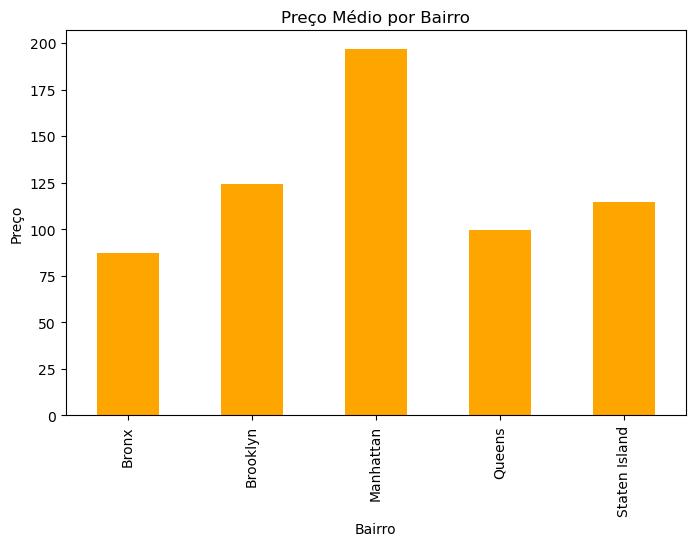

In [16]:
# 1.3 Preço médio por bairro principal gráfico(bairro_group)

p_medio_bairro.plot(kind="bar", figsize=(8, 5), color="orange", title="Preço Médio por Bairro")
plt.xlabel("Bairro")
plt.ylabel("Preço")

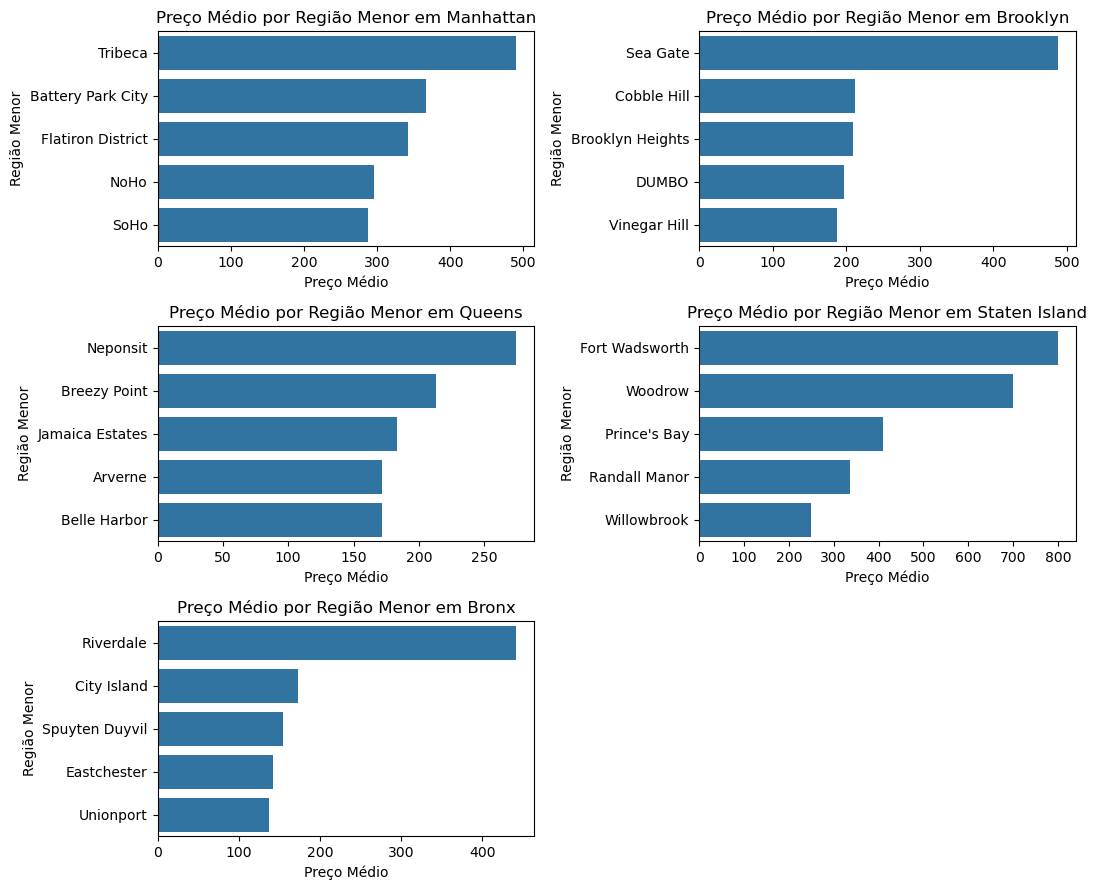

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Obter os bairros principais
bairro_principal = apts_price["bairro_group"].unique()
n_bairros = len(bairro_principal)

# Criar subplots com o número de bairros principais
n_colunas = 2
n_linhas = int(np.ceil(n_bairros / n_colunas))

fig, axs = plt.subplots(n_linhas, n_colunas, figsize=(11, 3 * n_linhas))
axs = axs.ravel()
plot_idx = 0

for i, bp in enumerate(bairro_principal):
    # Filtrar os dados do bairro principal
    dados_bairro_principal = apts_price[apts_price["bairro_group"] == bp]
    top_5_sub_bairros = (
        dados_bairro_principal.groupby("bairro")["price"]
        .mean()
        .nlargest(5)
        .reset_index()
    )
    sns.barplot(x="price", y="bairro", data=top_5_sub_bairros, ax=axs[i])
    axs[i].set_title(f'Preço Médio por Região Menor em {bp}')
    axs[i].set_xlabel('Preço Médio')
    axs[i].set_ylabel('Região Menor')
    plot_idx += 1

for j in range(plot_idx, len(axs)):
    fig.delaxes(axs[j])
    
plt.tight_layout()
plt.savefig('preco_medio_por_Região Menor.png')
plt.show()

In [18]:
#2- Dados tipo de Quarto
# 2.1 Tipo mais frequente
acomodacao_mais_comum = apts_price["room_type"].value_counts()
print(f"Acomodação mais comum para aluguel: {acomodacao_mais_comum}")

Acomodação mais comum para aluguel: room_type
Entire home/apt    25402
Private room       22317
Shared room         1159
Name: count, dtype: int64


In [19]:
# 2.2- Preço por Tipo de Acomodação
room_types = apts_price["room_type"].unique()

p_medio_type = apts_price.groupby("room_type")["price"].mean()
for room, price in p_medio_type.items():
    print(f"{room}: {price:.2f}")


Entire home/apt: 211.80
Private room: 89.82
Shared room: 70.22


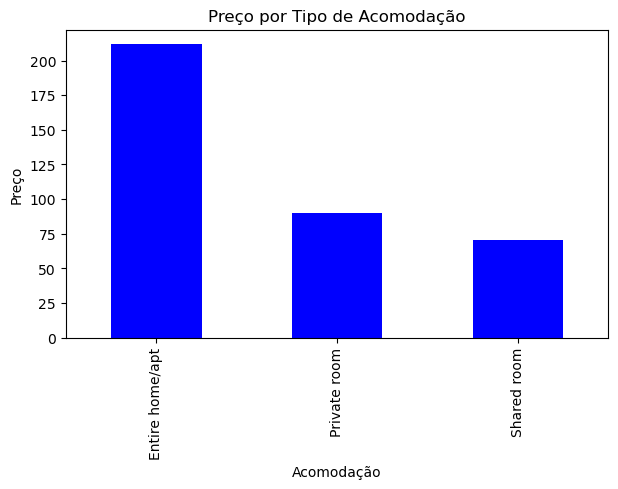

In [20]:
p_medio_type.plot(kind="bar", figsize=(7, 4), color="blue", title=f"Preço por Tipo de Acomodação")
plt.xlabel("Acomodação")
plt.ylabel("Preço")
plt.show()

In [21]:
#3- Dados Minimo de Notes
# 3.1 Minimo mais Frequente
minimo_noite_mais_comum = apts_price["minimo_noites"].mode()
print(f"Minimo de noites mais Frequente: {minimo_noite_mais_comum.iloc[0]}")

Minimo de noites mais Frequente: 1


In [22]:
# 3.2 Minimo Minimo de Noites Registrado
minimo_minimo_noite = apts_price["minimo_noites"].min()
print(f"Minimo de Noites Registrado é: {minimo_minimo_noite}")

# 3.3 Maior Minimo de Noites Registrado
minimo_maximo_noite = apts_price["minimo_noites"].max()
print(f"Maior Minimo de Noites Registrado é: {minimo_maximo_noite}")

# 3.4 Média Minimo de Noites
media_minimo_noite = apts_price["minimo_noites"].mean()
print(f"Média Minimo de Noites é: {media_minimo_noite:.2f}")

apts_price['minimo_noites'].describe().round(2)

Minimo de Noites Registrado é: 1
Maior Minimo de Noites Registrado é: 1250
Média Minimo de Noites é: 7.01


count    48878.00
mean         7.01
std         20.02
min          1.00
25%          1.00
50%          3.00
75%          5.00
max       1250.00
Name: minimo_noites, dtype: float64

In [23]:
#4 - Dados Reviews
# 4.1 Número Máximo de Reviews
nbr_maximo_review = apts_price["numero_de_reviews"].max()
print(f"Número Máximo de Reviews Registrado: {nbr_maximo_review}")

# 4.2 Número Mínimo de Reviews
nbr_minimo_review = apts_price["numero_de_reviews"].min()
print(f"Número Mínimo de Reviews Registrado: {nbr_minimo_review}")

# 4.3 Média de Reviews
media_review = apts_price["numero_de_reviews"].mean()
print(f"Média de Reviews: {media_review:.2f}")

# 4.4 Quantidade de Reviews Mais frequente
moda_review = apts_price["numero_de_reviews"].mode()
print(f"Quantidade de Reviews Mais frequente: {moda_review.iloc[0]}")

apts_price["numero_de_reviews"].describe().round(2)

Número Máximo de Reviews Registrado: 629
Número Mínimo de Reviews Registrado: 0
Média de Reviews: 23.28
Quantidade de Reviews Mais frequente: 0


count    48878.00
mean        23.28
std         44.56
min          0.00
25%          1.00
50%          5.00
75%         24.00
max        629.00
Name: numero_de_reviews, dtype: float64

In [24]:
# 4.5 Review mais Recente
print("\nData das Reviews")
apts_price["ultima_review"] = pd.to_datetime(apts_price["ultima_review"],  errors="coerce")
data_mais_recente = apts_price["ultima_review"].max()
print(f"Data da Review Mais Recente: {data_mais_recente.date()}")

# 4.6 Review mais Antiga
data_mais_antiga = apts_price["ultima_review"].min()
print(f"Data da Review Mais Antiga: {data_mais_antiga.date()}")


Data das Reviews
Data da Review Mais Recente: 2019-07-08
Data da Review Mais Antiga: 2011-03-28


In [25]:
# 4.7 Maior Número de Reviews por Mês
print("\nReviews por Mês")
max_review_mes = apts_price["reviews_por_mes"].max()
print(f"Maior Número de Reviews Registrados num Mês: {max_review_mes}")

# 4.8 Média de Review por Mês
media_review_mes = apts_price["reviews_por_mes"].mean()
print(f"Média Registrada de Reviews num Mês: {media_review_mes:.2f}")

# 4.9 Quantidade de Reviews Mais Frequente por Mês
moda_review_mes = apts_price["reviews_por_mes"].mode()
print(f"Quantidade de Reviews Mais Frequente por Mês: {moda_review_mes.iloc[0]}")

apts_price["reviews_por_mes"].describe().round(2)


Reviews por Mês
Maior Número de Reviews Registrados num Mês: 58.5
Média Registrada de Reviews num Mês: 1.09
Quantidade de Reviews Mais Frequente por Mês: 0.0


count    48878.00
mean         1.09
std          1.60
min          0.00
25%          0.04
50%          0.37
75%          1.58
max         58.50
Name: reviews_por_mes, dtype: float64

In [26]:
#5 Dados Disponibilidades de Dias
# 5.1 Maior Disponibilidade
max_disponibilidade = apts_price["disponibilidade_365"].max()
print(f"Maior disponíbilidade: {max_disponibilidade}")

# 5.2 Menor Disponibilidade 
min_disponibilidade = apts_price["disponibilidade_365"].min()
print(f"Menor disponíbilidade: {min_disponibilidade}")

# 5.3 Disponibilidade Mais Frequente
moda_disponibilidade = apts_price["disponibilidade_365"].mode()
print(f"Disponibilidade Mais Frequente: {moda_disponibilidade.iloc[0]}")
apts_price["disponibilidade_365"].describe().round(2)

Maior disponíbilidade: 365
Menor disponíbilidade: 0
Disponibilidade Mais Frequente: 0


count    48878.00
mean       112.78
std        131.61
min          0.00
25%          0.00
50%         45.00
75%        227.00
max        365.00
Name: disponibilidade_365, dtype: float64

In [27]:
#6 Quantidade de listagem por host
# 6.1 Maior número de listagens
max_listings = apts_price["calculado_host_listings_count"].max()
print(f"Maior número de listagens: {max_listings}")

# 6.2 Menor número de listagens
min_listings = apts_price["calculado_host_listings_count"].min()
print(f"Menor número de listagens: {min_listings}")

# 6.3 Média de listagens
media_listings = apts_price["calculado_host_listings_count"].mean()
print(f"Média de listagens: {media_listings:.2f}")

apts_price["calculado_host_listings_count"].describe().round(2)

Maior número de listagens: 327
Menor número de listagens: 1
Média de listagens: 7.15


count    48878.00
mean         7.15
std         32.96
min          1.00
25%          1.00
50%          1.00
75%          2.00
max        327.00
Name: calculado_host_listings_count, dtype: float64

In [28]:
#7 Preço
# 7.1 Maior Preço
max_price = apts_price["price"].max()
print(f"Maior Preço: {max_price}")

# 7.2 Menor Preço
min_price = apts_price["price"].min()
print(f"Menor Preço: {min_price}")

# 7.3 Preço Médio
medio_preco = apts_price["price"].mean()
print(f"Preço Médio: {medio_preco:.2f}")

# 7.4 Preço Mais Frequente
moda_preco = apts_price["price"].mode()
print(f"Preço Mais Frequente: {moda_preco.iloc[0]}")

apts_price["price"].describe().round(2)

Maior Preço: 10000.0
Menor Preço: 10.0
Preço Médio: 152.75
Preço Mais Frequente: 100.0


count    48878.00
mean       152.75
std        240.18
min         10.00
25%         69.00
50%        106.00
75%        175.00
max      10000.00
Name: price, dtype: float64

In [29]:
# Nomes das acomodações mais caras
apts_price_ordenado = apts_price.sort_values(by="price", ascending=False)
top_mais_caras = apts_price_ordenado.head(20)
nome_mais_caras = top_mais_caras[["nome", "price"]]
print(nome_mais_caras)

                                                    nome    price
17691    Luxury 1 bedroom apt. -stunning Manhattan views  10000.0
29237                                1-BR Lincoln Center  10000.0
9150                 Furnished room in Astoria apartment  10000.0
40432  2br - The Heart of NYC: Manhattans Lower East ...   9999.0
12341                Quiet, Clean, Lit @ LES & Chinatown   9999.0
6529                                  Spanish Harlem Apt   9999.0
30267  Beautiful/Spacious 1 bed luxury flat-TriBeCa/Soho   8500.0
4376                                       Film Location   8000.0
29661          East 72nd Townhouse by (Hidden by Airbnb)   7703.0
42522                70' Luxury MotorYacht on the Hudson   7500.0
45665                               Gem of east Flatbush   7500.0
44033                   3000 sq ft daylight photo studio   6800.0
3773                    SUPER BOWL Brooklyn Duplex Apt!!   6500.0
37193               Apartment New York \nHell’s Kitchens   6500.0
48042     

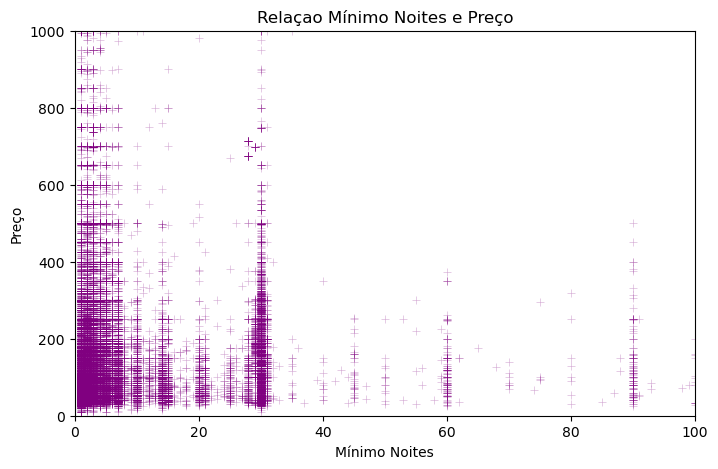

In [30]:
#checar relaçao entre mínimo_noites com preço
plt.figure(figsize=(8,5))
sns.scatterplot(x=apts_price["minimo_noites"], y=apts_price["price"], alpha=0.3 ,color="purple", marker="+")
plt.xlim(0, 100)
plt.ylim(0,1000)
plt.title("Relaçao Mínimo Noites e Preço")
plt.xlabel("Mínimo Noites")
plt.ylabel("Preço")
plt.show()

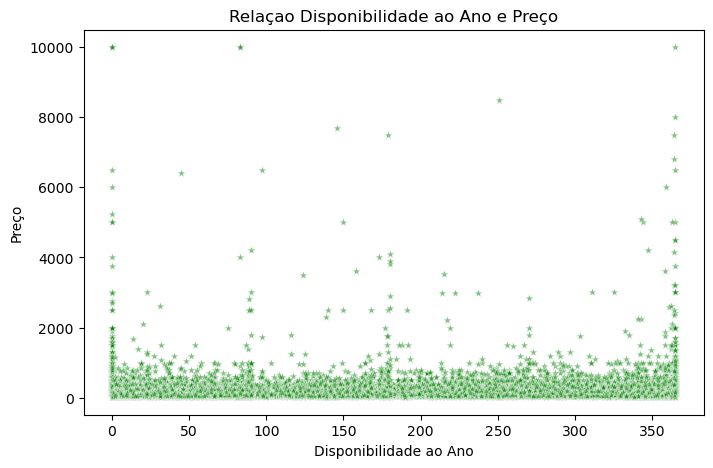

In [31]:
#checar relação entre disponobilidade no ano com preço
plt.figure(figsize=(8,5))
sns.scatterplot(x=apts_price["disponibilidade_365"], y=apts_price["price"], alpha=0.5 ,color="green", marker="*")
plt.title("Relaçao Disponibilidade ao Ano e Preço")
plt.xlabel("Disponibilidade ao Ano")
plt.ylabel("Preço")
plt.show()

In [32]:
# verificar palavras chaves
apts_price["nome"] = apts_price["nome"].str.lower()
key_words = ["luxury", "mansion", "penthouse", "townhouse", "hidden by airbnb", "superbowl"]

for key in key_words:
    room_key = apts_price[apts_price["nome"].str.contains(key, case=False, na=False)]
    preco_medio_room_key = room_key["price"].dropna().mean()
    print(f"O preço médio da acomodações com a palavras {key} é {preco_medio_room_key:.2f}")

room_noword = apts_price[~apts_price["nome"].str.contains("|".join(key_words), na=False)]
preco_medio_room_noword = room_noword["price"].dropna().mean()
print(f"O preço médio das acomodaçoes, desconsiderando palavras chave {preco_medio_room_noword:.2f}")

O preço médio da acomodações com a palavras luxury é 271.57
O preço médio da acomodações com a palavras mansion é 500.39
O preço médio da acomodações com a palavras penthouse é 297.58
O preço médio da acomodações com a palavras townhouse é 355.52
O preço médio da acomodações com a palavras hidden by airbnb é 1516.11
O preço médio da acomodações com a palavras superbowl é 1439.71
O preço médio das acomodaçoes, desconsiderando palavras chave 144.32


Uma clara correlação entre preço e bairro. Alugueis na região de Manhattan tem preços maiores. Enquanto, alugueis no Bronx tem preço menores.

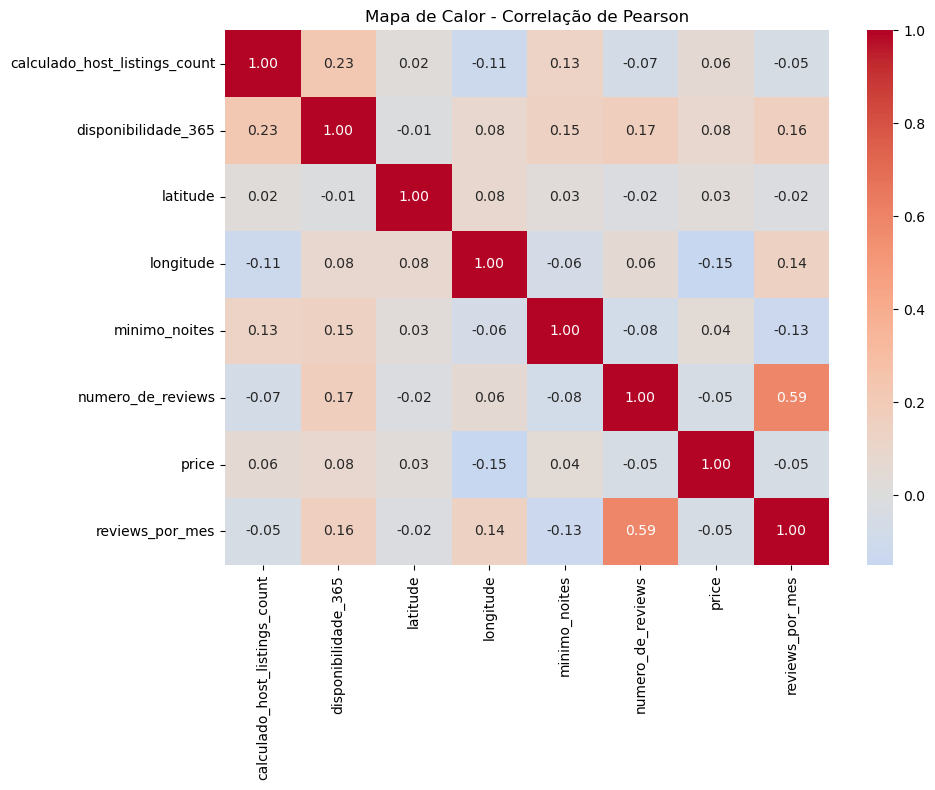

In [33]:
# correlaçao Person 

numeric_columns = apts_price.select_dtypes(include=[np.number]).columns
correlation_matrix = apts_price[numeric_columns.difference(['id', 'host_id'])].corr(method='pearson')

# Criando o mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Mapa de Calor - Correlação de Pearson')
plt.tight_layout()
plt.savefig('mapa_de_calor.png')
plt.show()

In [40]:
# modelo Random Forest

remove_columns = [ "id", "nome", "host_id", "host_name", "ultima_review"]
data_cleaned = apts_price.drop(columns=remove_columns, axis=1)

categorical_var = ["bairro_group", "bairro", "room_type"]
data_encoded = pd.get_dummies(data_cleaned, columns=categorical_var, drop_first=True)

X = data_encoded.drop("price", axis=1)
y = data_encoded["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape
print("Random Forest")
# Criando modelo Random Forest
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest.fit(X_train, y_train)

y_pred = random_forest.predict(X_test)
print(y_pred[0])

# Estatísticas
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)
print(f"mae: {mae:.2f}")
print(f"mse: {mse:.2f}")
print(f"rmse: {rmse:.2f}")
print(f"r2: {r2:.2f}")

Random Forest
104.29
mae: 65.82
mse: 43306.00
rmse: 208.10
r2: 0.05


In [41]:
# modelo Regressão Linear
print("Regressão Linear")
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)
print(y_pred[0])

# Estatísticas
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"mae: {mae:.2f}")
print(f"mse: {mse:.2f}")
print(f"rmse: {rmse:.2f}")
print(f"r2: {r2:.2f}")

Regressão Linear
129.5942666530973
mae: 69.96
mse: 39894.09
rmse: 199.74
r2: 0.12


In [42]:
import pickle

with open('modelo.pkl', 'wb') as file:
    pickle.dump(regressor, file)